## 场景描述：
对不同用户（每各用户作为一个事务）使用过的电信产品清单进行分析，试图挖掘哪些电信产品存在相关性，或者哪些地区的用户更倾向于订购哪种套餐。

注：请在操作手册中注明一下：编码只是示例，不代表和商用真实编码相同，套餐属性也不代表和真实商用套餐相同。

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pylab as plt
%matplotlib inline

The dataset we are using today comes from UCI Machine Learning repository. The dataset is called “Online Retail” and can be found here. It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered online retailer.

In [2]:
data = pd.read_csv("Correlation.csv",sep = ' ',encoding = 'utf-8')
df = data.sample(10000,random_state=10)
df.head(10)

,用户标识,注册地市,套餐代码A,套餐代码B,套餐代码C,套餐代码D,套餐代码E,套餐代码F,套餐代码G,套餐代码H
739812,8891092281,579,90151624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576949,8421759670,574,90199605,90151622.0,NaN,NaN,NaN,NaN,NaN,NaN
154700,8362433718,574,90065148,90157638.0,NaN,NaN,NaN,NaN,NaN,NaN
13735,8098774732,575,90151624,90065148.0,NaN,NaN,NaN,NaN,NaN,NaN
828049,8985898005,573,90063345,90129503.0,NaN,NaN,NaN,NaN,NaN,NaN
451337,8345509461,580,90157638,90129503.0,NaN,NaN,NaN,NaN,NaN,NaN
838332,8420273106,574,90063345,90129503.0,NaN,NaN,NaN,NaN,NaN,NaN
240926,8738526605,578,90065147,90151621.0,NaN,NaN,NaN,NaN,NaN,NaN
626040,8854160000,578,90109906,90151621.0,NaN,NaN,NaN,NaN,NaN,NaN
9878,8884936691,574,90138402,90215356.0,90199605.0,NaN,NaN,NaN,NaN,NaN


In [3]:
#显示数据信息
print("The shape of the data:{}".format(df.shape))
df.info()

The shape of the data:(10000, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 739812 to 62329
Data columns (total 10 columns):
用户标识     10000 non-null int64
注册地市     10000 non-null int64
套餐代码A    10000 non-null int64
套餐代码B    8261 non-null float64
套餐代码C    4579 non-null float64
套餐代码D    1783 non-null float64
套餐代码E    582 non-null float64
套餐代码F    84 non-null float64
套餐代码G    0 non-null float64
套餐代码H    0 non-null float64
dtypes: float64(7), int64(3)
memory usage: 859.4 KB


In [5]:
#分组统计
grouped_df = df.groupby([u'注册地市']).count()
grouped_df.head(20)

,用户标识,套餐代码A,套餐代码B,套餐代码C,套餐代码D,套餐代码E,套餐代码F,套餐代码G,套餐代码H
注册地市,,,,,,,,,
570,844,844,689,376,163,56,11,0,0
571,815,815,660,358,147,44,2,0,0
572,831,831,692,387,143,50,4,0,0
573,827,827,678,374,148,59,9,0,0
574,882,882,733,383,160,42,6,0,0
575,847,847,695,416,164,58,13,0,0
576,803,803,644,369,139,35,3,0,0
577,826,826,693,391,138,42,5,0,0
578,814,814,670,346,129,40,5,0,0


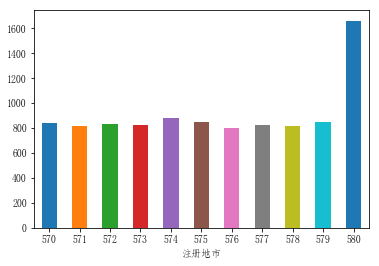

In [28]:
grouped_df['用户标识'].plot(kind= 'bar',rot=0)

## Data preprocessing

### One Hot Encoding
After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. 

In [30]:
#生成标记每个用户的注册地市的初始字典
location_list = df['注册地市'].drop_duplicates().values.tolist()
location_list.sort()
location_dict_0 =  dict(zip(location_list,np.zeros(len(location_list),dtype =int)))
print(location_dict_0)

{570: 0, 571: 0, 572: 0, 573: 0, 574: 0, 575: 0, 576: 0, 577: 0, 578: 0, 579: 0, 580: 0}


In [9]:
#定义转换函数
def oneHotCode_locationMap(row):
    location_dict =location_dict_0.copy()
    location = row['注册地市']
    location_dict.update({location:1})
    return location_dict

#对每行进行转换
location_series = df.apply(oneHotCode_locationMap,axis=1)

#生成注册地市的oneHotCode编码信息的df
location_df = pd.DataFrame(location_series.values.tolist(),index = location_series.index)

location_df.head()

,570,571,572,573,574,575,576,577,578,579,580
739812,0,0,0,0,0,0,0,0,0,1,0
576949,0,0,0,0,1,0,0,0,0,0,0
154700,0,0,0,0,1,0,0,0,0,0,0
13735,0,0,0,0,0,1,0,0,0,0,0
828049,0,0,0,1,0,0,0,0,0,0,0


In [37]:
#生成用户套餐的集合
service_set =set()
for x in list('ABCDEFGH'):
    column = '套餐代码'+x
    service_set.update(set(df[column].drop_duplicates().values.tolist()))

# print(service_set)

#去除空值,生成用户套餐的初始化字典
s = pd.Series(list(service_set))
s.dropna(inplace=True)

service_list = s.sort_values().tolist()

service_dict_0 =  dict(zip(service_list,np.zeros(len(service_list),dtype =int)))
print(service_dict_0)

{90046637.0: 0, 90046638.0: 0, 90063345.0: 0, 90065147.0: 0, 90065148.0: 0, 90109906.0: 0, 90109916.0: 0, 90127327.0: 0, 90129503.0: 0, 90138402.0: 0, 90151621.0: 0, 90151622.0: 0, 90151624.0: 0, 90157593.0: 0, 90157638.0: 0, 90163763.0: 0, 90199605.0: 0, 90215356.0: 0}


In [38]:
#定义套餐代码的转换函数
def oneHotCode_serviceMap(row):
    service_dict =service_dict_0.copy()
#     print('before',service_dict)
    for column in df.columns.tolist()[2:]:
        service = row[column]
        if service in service_list:
            service_dict.update({service:1})
#     print('after',service_dict) 
    return service_dict

#生成0/1编码形式的套餐代码df
service_series = df.apply(oneHotCode_serviceMap,axis=1)
service_df = pd.DataFrame(service_series.values.tolist(),index= service_series.index)
service_df.head()

,90046637.0,90046638.0,90063345.0,90065147.0,90065148.0,90109906.0,90109916.0,90127327.0,90129503.0,90138402.0,90151621.0,90151622.0,90151624.0,90157593.0,90157638.0,90163763.0,90199605.0,90215356.0
739812,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
576949,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
154700,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
13735,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
828049,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [14]:
#生成0/1编码格式的df
new_df=pd.concat([location_df,service_df],axis =1)
new_df.set_index(df['用户标识'],inplace=True)
new_df.head()

,570.0,571.0,572.0,573.0,574.0,575.0,576.0,577.0,578.0,579.0,...,90129503.0,90138402.0,90151621.0,90151622.0,90151624.0,90157593.0,90157638.0,90163763.0,90199605.0,90215356.0
用户标识,,,,,,,,,,,,,,,,,,,,,
8891092281,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
8421759670,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8362433718,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8098774732,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8985898005,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
#生成编码：说明的字典
map_dict = {570:'衢州',571:'杭州',572:'湖州',573:'嘉兴',574:'宁波',575:'绍兴',576:'台州',577:'温州',578:'丽水',579:'金华',
580:'舟山',580:'舟山群岛新区',90046637:'腾讯视频小王卡',90046638:'腾讯呢音频小王卡',90063345:'腾讯大王卡',90065147:'滴滴大王卡',
90065148:'滴滴小王卡',90109906:'蚂蚁小宝卡',90109916:'蚂蚁大宝卡',90127327:'百度大神卡',90129503:'京东小强卡',
90138402:'招行大招卡',90151621:'滴滴大橙卡',90151622:'微博大V卡',90151624:'滴滴小橙卡',90157593:'百度女神卡',
90157638:'哔哩哔哩22卡',90163763:'饿了么大饿卡',90199605:'懂我卡',90215356:'阿里YunOS-9元卡',
}

new_column = new_df.columns.map(lambda x:map_dict.get(x))

#替换为新的列
new_df.columns = new_column
new_df.head()

,衢州,杭州,湖州,嘉兴,宁波,绍兴,台州,温州,丽水,金华,...,京东小强卡,招行大招卡,滴滴大橙卡,微博大V卡,滴滴小橙卡,百度女神卡,哔哩哔哩22卡,饿了么大饿卡,懂我卡,阿里YunOS-9元卡
用户标识,,,,,,,,,,,,,,,,,,,,,
8891092281,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
8421759670,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8362433718,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8098774732,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8985898005,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [17]:
#创建频繁集
# Now that the data is structured properly, we can generate frequent item sets 
# that have a support of at least 5% 
# (this number was chosen so that I could get enough useful examples):

frequent_itemsets = apriori(new_df, min_support=0.05, use_colnames=True)

### confidence

In [1]:
0.0664/0.3898

0.17034376603386353

### lift

In [2]:
0.170344/0.1661

1.0255508729680916

In [18]:
# 创建关联规则
# The final step is to generate the rules with their corresponding support, 
# confidence and lift:
rules = association_rules(frequent_itemsets, metric="confidence",
                          min_threshold=0.01)
rules

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(哔哩哔哩22卡),(舟山群岛新区),0.3898,0.1661,0.0664,0.170344,1.025549,0.001654,1.005115
1,(舟山群岛新区),(哔哩哔哩22卡),0.1661,0.3898,0.0664,0.399759,1.025549,0.001654,1.016592
2,(哔哩哔哩22卡),(滴滴小王卡),0.3898,0.1283,0.0511,0.131093,1.021768,0.001089,1.003214
3,(滴滴小王卡),(哔哩哔哩22卡),0.1283,0.3898,0.0511,0.398285,1.021768,0.001089,1.014102
4,(百度大神卡),(哔哩哔哩22卡),0.1304,0.3898,0.0507,0.388804,0.997444,-0.000130,0.998370
5,(哔哩哔哩22卡),(百度大神卡),0.3898,0.1304,0.0507,0.130067,0.997444,-0.000130,0.999617


In [19]:
import networkx as nx
import numpy as np

In [20]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [21]:
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
        for a in rules.iloc[i]['antecedants']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, 
            width=weights, font_size=16, with_labels=False)            
    for p in pos:  # raise text positions
           pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()

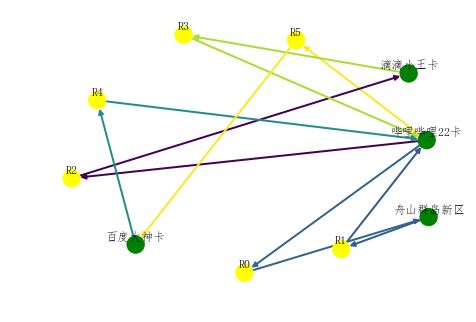

In [39]:
draw_graph(rules,6)
# plt.show()

In [23]:
#显示confidence>= 0.3的关联规则
rules[ (rules['confidence'] >= 0.3) ]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(舟山群岛新区),(哔哩哔哩22卡),0.1661,0.3898,0.0664,0.399759,1.025549,0.001654,1.016592
3,(滴滴小王卡),(哔哩哔哩22卡),0.1283,0.3898,0.0511,0.398285,1.021768,0.001089,1.014102
4,(百度大神卡),(哔哩哔哩22卡),0.1304,0.3898,0.0507,0.388804,0.997444,-0.000130,0.998370
